# Find Distribution of Theta Frequencies in iEEG Signal

In [66]:
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Import the data loading utilities
import neuropsy as npsy
import neuropsy.analysis as npsya

# Import the spectral parameterization object and utilities
from fooof import FOOOF, FOOOFGroup
from fooof.plts import plot_spectra
from fooof.utils import trim_spectrum

# Import NeuroDSP functions for processing time series
from neurodsp.spectral import compute_spectrum

In [ ]:
#********** PARAMETERS **********#
stimulus                    = 'Picture Placed'
hp_subfield                 = 'body & tail'
chan_label_method           = 'strict' # [IMPORTANT] change this to 'strict' or 'soft' to analyse data from strict or soft labelling

path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_results                = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/fooof'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)

postfix_load                = 'preprocessed'
dict_subfields_regex        = {'all': r'Right_HP_head|Left_HP_head|Right_HP_body|Left_HP_body|Right_HP_tail|Left_HP_tail', 
                               'head': r'Right_HP_head|Left_HP_head', 
                               'body & tail': r'Right_HP_body|Left_HP_body|Right_HP_tail|Left_HP_tail'}

# analysis parameters
tmin                        = 0  # in seconds
tmax                        = 2  # in seconds
fmin                        = 2  # in Hz
fmax                        = 32 # in Hz
fs                          = 512 # in Hz

# FOOOF parameters
freq_range                  = [2, 12]
peak_width_limits           = [1, 4]
max_n_peaks                 = 6
min_peak_height             = 0.2
aperiodic_mode              = 'fixed'

# set up directory for saving results
if not os.path.exists(path_results):
    os.makedirs(path_results)
    os.makedirs(f"{path_results}/data")

	Starting subject 03...
	Selecting channels in hippocampus...
	Selected 2 channels in hippocampus 'body & tail'.
	Removing outliers from experiment dataframe...
	Checking trial durations...
Creating RawArray with float64 data, n_channels=2, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Getting trial indices...
		Starting channel C' 01...
		Channel C' 01 done - 0.29 seconds
		Starting channel C' 02...
		Channel C' 02 done - 0.24 seconds
	Starting subject 04...
	Selecting channels in hippocampus...
	Selected 3 channels in hippocampus 'body & tail'.
	Removing outliers from experiment dataframe...
	Checking trial durations...
Creating RawArray with float64 data, n_channels=3, n_times=868110
    Range : 0 ... 868109 =      0.000 ...  1695.525 secs
Ready.
	Getting trial indices...
		Starting channel C 02...
		Channel C 02 done - 0.16 seconds
		Starting channel C' 01...
		Channel C' 01 done - 0.14 seconds
		Starting channel C' 02...
		Channel C' 02 done - 0.1

Running FOOOFGroup:   0%|          | 0/5935 [00:00<?, ?it/s]

/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/fooof/objs/fit.py:1161: OptimizeWarning: Covariance of the parameters could not be estimated
  gaussian_params, _ = curve_fit(gaussian_function, self.freqs, self._spectrum_flat,
/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/fooof/objs/fit.py:1161: OptimizeWarning: Covariance of the parameters could not be estimated
  gaussian_params, _ = curve_fit(gaussian_function, self.freqs, self._spectrum_flat,
/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/fooof/objs/fit.py:1161: OptimizeWarning: Covariance of the parameters could not be estimated
  gaussian_params, _ = curve_fit(gaussian_function, self.freqs, self._spectrum_flat,
/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/fooof/objs/fit.py:1161: OptimizeWarning: Covariance of the parameters could not be estimated
  gaussian_params, _ = curve_fit(gaussian_function, self.freqs, self._spectrum_flat,
/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/foo

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 5935                            
                                                                                                  
                        The model was run on the frequency range 2 - 12 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

/tmp/ipykernel_16293/3351026613.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


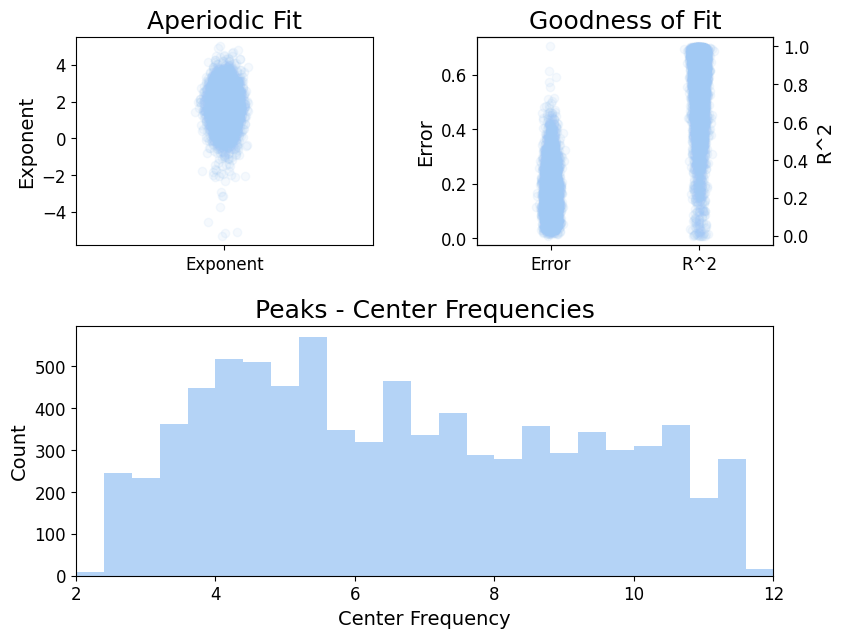

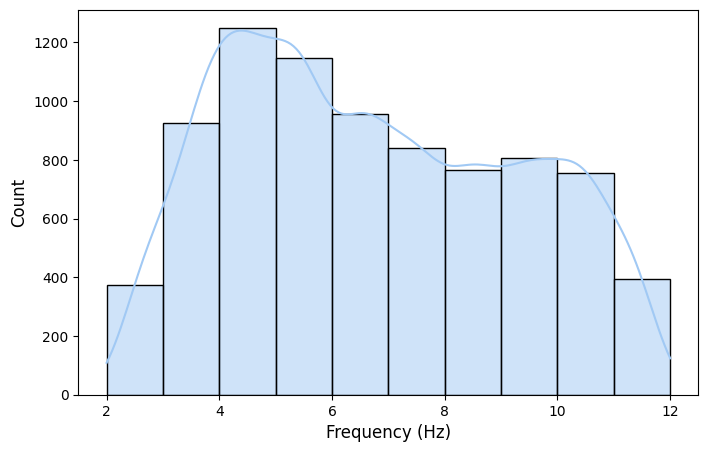

In [85]:
power_spectra = []
#********** START ANALYSIS **********#
for subject_id in subject_ids:
    
    start_time_sub = time.time()
    print(f"\tStarting subject {subject_id}...")
    
    #********** LOAD SUBJECT DATA **********# 
    postfix_chan = postfix_load + '-' + chan_label_method
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_load, load_exp=True, load_ieeg=True, load_chan=True, load_targets=False, load_ied=True, postfix_chan=postfix_chan)
        
    #********** SELECT CHANNELS TO INCLUDE IN ANALYSIS **********# 
    print(f"\tSelecting channels in hippocampus...")
    regex_pattern = dict_subfields_regex[hp_subfield]
    ch_names = data.df_chan[data.df_chan['HC_Subfields'].str.contains(regex_pattern, regex=True, case=False, na=False)]['name'].tolist()
    # check that there are channels in the hippocampal subfield for this subject, otherwise skip
    if len(ch_names) > 0:
        data.select_channels(ch_names=np.ravel(ch_names), inplace=True)
        print(f"\tSelected {len(ch_names)} channels in hippocampus {repr(hp_subfield)}.")
    else:
        print(f"Subject {subject_id} has no channels in the hippocampal subfield {repr(hp_subfield)}, skipping subject...")
    
    #********** REMOVE OUTLIERS (TRIALS WITH TOO HIGH REACTION TIME)  **********# 
    print("\tRemoving outliers from experiment dataframe...")
    idx_outliers = data.df_exp[data.df_exp['outlier'] == True]['outlier'].index.to_list()
    if len(idx_outliers) > 0:
        trial_names_outliers    = data.df_exp[data.df_exp['outlier'] == True]['Trial Identifier'].to_list()
        data.df_exp = data.df_exp.drop(idx_outliers).reset_index(drop=True)
    else:
        print("\tNo outliers in experiment dataframe.")

    # [INFO] need to make sure trials have enough time points for the chosen tmax
    #********** CHECK TRIAL DURATIONS **********# 
    print("\tChecking trial durations...")
    idx_too_short, _ = npsya.check_trials(df=data.df_exp, tmin=tmin, tmax=tmax, baseline=None)
    if stimulus == 'Picture Shown':
        # trials with too few time points
        if len(idx_too_short) > 0:
            print(f"\t{len(idx_too_short)} trials are too short, removing from experiment dataframe.")
            trial_names_too_short  = data.df_exp.loc[idx_too_short, 'Trial Identifier'].to_list()
            data.df_exp = data.df_exp.drop(idx_too_short).reset_index(drop=True)
        else:
            print("\tNo trials are too short.")

    #********** CREATE MNE RAW OBJECT **********#
    # - the raw object will only contain the previously selected channels
    data.create_mne_raw()
    

    #********** GET TRIAL TIME POINTS (INDICES) AND TRIAL IDENTIFIERS (NAMES) **********#
    # - need trial indices from experiment dataframe
    # - also need the corresponding trial indices for the baseline (picture shown)
    # - also need to extract the trial identifiers (names) to keep track of trials in the resulting time-frequency power data
    print("\tGetting trial indices...")
    dict_trial_indices = {**{'stimulus': None}, **{'names': None}}
    # get the trial indices
    idx_stimulus                        = data.df_exp[f'Mark for {stimulus}'].to_numpy().astype(int)
    # save indices
    dict_trial_indices["stimulus"]      = idx_stimulus
    # get the trial identifiers (names) for the condition
    trial_names                         = data.df_exp['Trial Identifier'].to_numpy().astype(str)
    # save trial identifiers
    dict_trial_indices["names"]         = trial_names
    
    #********** TIME-FREQUENCY ANALYSIS **********#
    # info
    dict_n_trials_kept = None
    dict_n_trials_ieds = None
    
    if len(ch_names) > 0:
        
        # CHANNEL:
        for ch in ch_names:
            start_time_ch = time.time()
            print(f"\t\tStarting channel {ch}...")
            
            # use the whole channel signal for computing time-frequency representation
            ch_signal = data.raw.get_data(ch)[0]
                
            # TRIAL:
            #  - consider each trial separately
            for (i_stimulus, trial_id) in zip(dict_trial_indices['stimulus'], dict_trial_indices['names']):
                start_time_trial = time.time()
                
                # get start and stop timepoints for trial period and baseline period
                i_tmin = int(i_stimulus + int(tmin * fs))
                i_tmax = int(i_stimulus + int(tmax * fs))
                
                #********** CHECK TRIAL FOR IEDs **********# 
                # - if there are IEDs in the trial, skip it and exclude it from the analysis
                # - if there are IEDs in the baseline, skip it and exclude it from the analysis
                if npsya.check_period_for_ieds(ch, data.df_ied, i_tmin, i_tmax):
                    # print(f"\t\t\t\tSkipping trial {trial_id} due to IEDs in trial period.")
                    continue
                
                #********** COMPUTE POWER SPECTRUM FOR TRIAL PERIOD **********# 
                # get signal for trial period
                trial_signal = ch_signal[i_tmin:i_tmax]
                # compute power spectrum for trial period
                freqs, power_spectrum = trim_spectrum(*compute_spectrum(trial_signal, fs, method='welch', avg_type='mean'), [fmin, fmax])
                # store power spectrum
                power_spectra.append(power_spectrum)
                
                # print(f"\t\t\tTrial {trial_id} done in {(time.time() - start_time_trial)*1000:.2f} milliseconds")
                # break
            print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
            # break
    # no channels
    else:
        # remove subject from results if there are no channels in the hippocampus
        print(f"\tNo channels in hippocampus for subject {subject_id}.")
        
    # break
    

#********** FOOOF **********#
# convert to numpy array
power_spectra = np.array(power_spectra)

fg = FOOOFGroup(peak_width_limits=peak_width_limits, max_n_peaks=max_n_peaks, min_peak_height=min_peak_height, aperiodic_mode=aperiodic_mode)
fg.fit(freqs, power_spectra, freq_range=freq_range, progress='tqdm.notebook', n_jobs=-1)

# Print out the results
fg.print_results()

# Save the results
fg.save(f"{path_results}/data/width=1,2 - {stimulus}_fooof_group_results_{hp_subfield if hp_subfield != 'all' else 'all'}", save_results=True, save_settings=True, save_data=True)

# Plot the results
fg.plot()

#********** PLOT USING SEABORN **********#
peaks = fg.get_params('peak_params', 'CF')

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(peaks[:, 0], bins=10, kde=True)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Count', fontsize=12)
# plt.title('Distribution of Peak Frequencies', fontsize=14)

# set colour of plot
sns.set_palette("pastel")

fig = ax.get_figure()
fig.show()

# save plot
fig.savefig(f"{path_results}/width=1,2 - {stimulus}_peak_distribution_{hp_subfield if hp_subfield != 'all' else 'all'}.png")

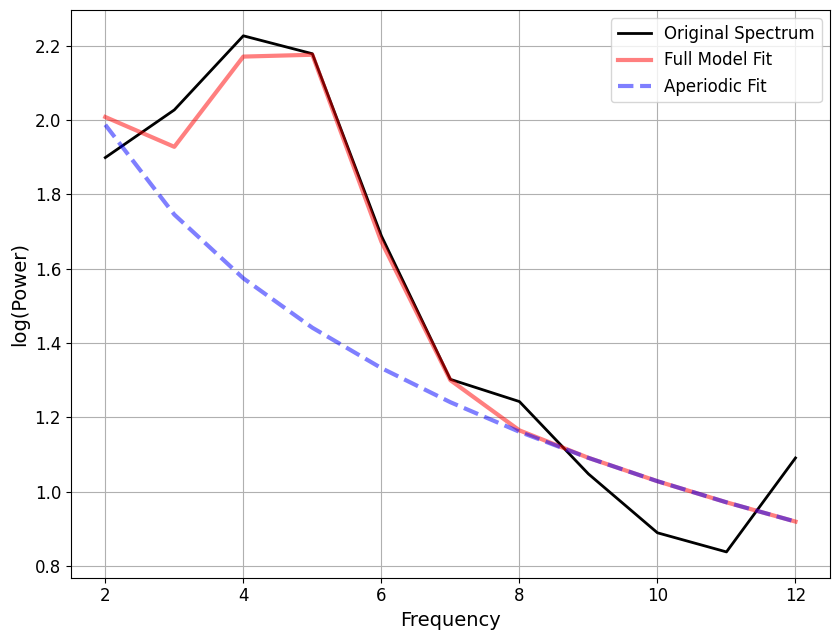

In [27]:
fm = fg.get_fooof(ind=48, regenerate=True)
fm.plot()